# Analysis CVC Sbcd (65dB) Nfront (65dB)

1 July 2023 Guido Cattani

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
from scipy.stats import wilcoxon as wilcoxon
from scipy.stats import rankdata as rankdata
from scipy.stats import shapiro as shapiro

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def cal_quantile(df):
    quantiles = [0.10, 0.50, 0.90]
    q = (df.quantile(q=quantiles)).round(2)
    q = q.reset_index()
    diq = {0:'CVC P10', 1:'CVC P50', 2:'CVC P90'} 
    q = q.rename(index=diq)
    q.drop('index', axis=1, inplace=True)
    return q

In [5]:
def read_CVC():
    f_in =  '/media/guido/LACIE/Cingle_Guido/Master/Implant/Calculated_data/CVC_Sbcd65_Nfront65.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in, index_col = 'Study_ID')
    df = df.fillna(pd.NA)
    return df

In [6]:
def descriptive_stat(df):
    # calculate quantiles
    quantiles = df.quantile([0.1, 0.5, 0.9]).round(1)
    quantiles.index = ['P10', 'P50', 'P90']
 
    # calculate mean and standard deviation
    mean_values = (pd.DataFrame({'Mean': df.mean().round(1)})).T
    std_values = (pd.DataFrame({'St. dev.': df.std().round(1)})).T

    # perform Shapiro test 
    sht = shapiro_test_norm(df)

    # combine results into a single DataFrame
    res = pd.concat([quantiles, mean_values, std_values, sht])
    
    return res.round(1)

In [7]:
def shapiro_test_norm(df):
    # check normality with Shapiro-Wilk test
    shapiro_result = df.apply(lambda x: shapiro(x) if len(x) >= 3 else (float('nan'), float('nan')))
    
    shapiro_stats = shapiro_result.apply(lambda x: round(x[0], 3))
    p_values = shapiro_result.apply(lambda x: round(x[1], 3))
    is_normal = p_values >= 0.05
    
    shapiro_test = pd.DataFrame({
        'Shapiro test statistic': shapiro_stats,
        'p-value': p_values,
        'normally distributed': is_normal
    }).transpose()
    
    return shapiro_test

In [8]:
cvc = read_CVC()
cvc

,AC_path,BC_path,AC&BC_path,diff_combi_AC
Study_ID,,,,
34,0.73,0.85,0.83,0.10
35,0.73,0.85,0.82,0.09
43,0.74,0.85,0.78,0.04
47,0.74,0.83,0.84,0.10
50,0.74,0.84,0.77,0.03
53,0.74,0.79,0.78,0.04
54,0.73,0.81,0.85,0.12
56,0.73,0.82,0.86,0.13
59,0.74,0.78,0.78,0.04


In [9]:
des_stat = descriptive_stat(cvc)
des_stat

,AC_path,BC_path,AC&BC_path,diff_combi_AC
P10,0.7,0.8,0.8,0.0
P50,0.7,0.8,0.8,0.1
P90,0.7,0.8,0.8,0.1
Mean,0.7,0.8,0.8,0.1
St. dev.,0.0,0.0,0.0,0.0
Shapiro test statistic,0.544,0.94,0.922,0.918
p-value,0.0,0.241,0.108,0.089
normally distributed,False,True,True,True


In [10]:
# name file quantiles results
f_ar = "CVC_SbcdNfront.csv"

# save quantiles to file
d_ar = "/media/guido/LACIE/Cingle_Guido/Master/Implant/Analysis_Results/"
p_ar = Path(d_ar + f_ar)
des_stat.to_csv(p_ar)

In [11]:
score = cvc.T.to_numpy()

In [12]:
# Wilcoxon signed-rank
w = wilcoxon(score[3])
w

WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)

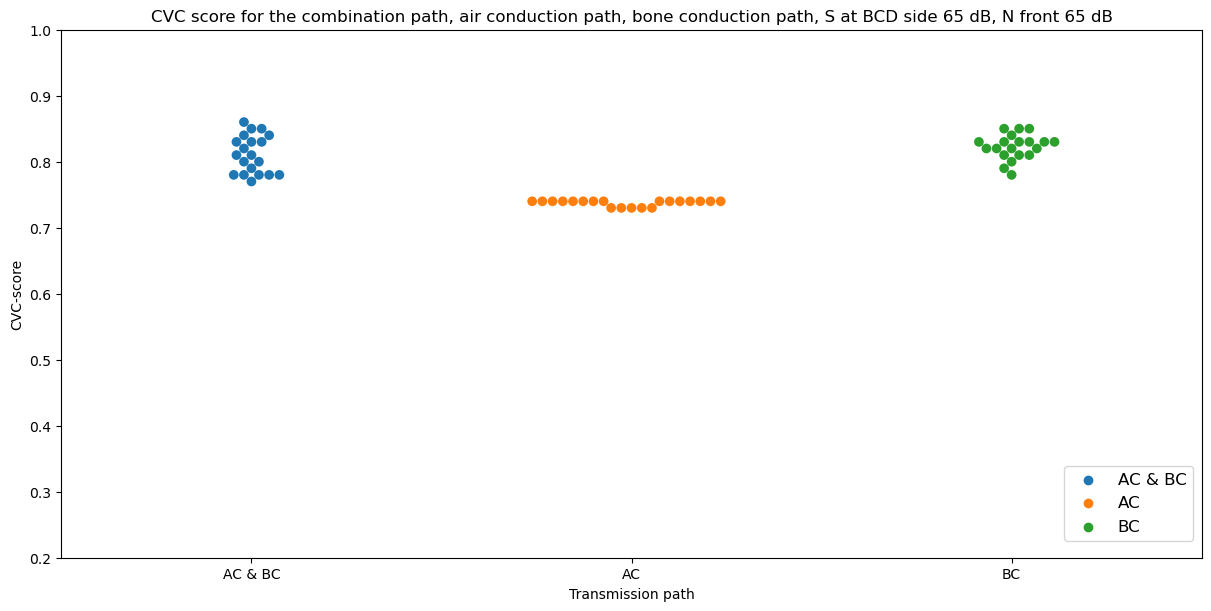

In [13]:
# make a figure to plot CVC score for the 3 paths
ttl = 'CVC score for the combination path, air conduction path, bone conduction path, S at BCD side 65 dB, N front 65 dB'
cvc_combi = cvc['AC&BC_path']
cvc_ac = cvc['AC_path']
cvc_bc = cvc['BC_path']
tp = pd.melt(pd.DataFrame( {'AC & BC' : cvc_combi, 'AC' : cvc_ac, 'BC' : cvc_bc }), 
             var_name = 'Transmission path', value_name = 'CVC-score') 

fig, ax = plt.subplots(constrained_layout=True)

sns.color_palette("colorblind")

fig.set_figheight(6)
fig.set_figwidth(12)

ax = sns.swarmplot(data = tp, x = 'Transmission path', y = 'CVC-score', hue = 'Transmission path', size=7)
ax.set_ylim(ymin=0.2, ymax=1)
ax.set_title(ttl)
plt.legend(bbox_to_anchor=(1, 0.19), fontsize='large')

# save the figure
plt.savefig('/media/guido/LACIE/Cingle_Guido/Master/Implant/Analysis_Graphs/CVC_SbcdNfront.tiff', 
            transparent=False, dpi=500, bbox_inches="tight")

plt.show()